In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    e = np.sum((np.abs((zr-np.real(ztot))))/(np.abs(zmag))) + \
        np.sum((np.abs((zj-np.abs(np.imag(ztot)))))/(np.abs(zmag)))

    L1 = e / n
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj_nolog.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r.png', dpi=300, bbox_inches='tight')
    
    # residual plots
    plt.figure()
    plt.title(title)
    plt.plot(f, (zj-zj_l1)/zj, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zj-zj_l2)/zj, 's-', label='Log10 L2 norm')
    plt.plot(f, (zj-zj_linf)/zj, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zj-zj_lk)/zj, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j_resid.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, (zr-zr_l1)/zr, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zr-zr_l2)/zr, 's-', label='Log10 L2 norm')
    plt.plot(f, (zr-zr_linf)/zr, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zr-zr_lk)/zr, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r_resid.png', dpi=300, bbox_inches='tight')
    plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
#     solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=25,
#                              limits=bounds, minimize=True)
    solver = pyfde.JADE(obj_function, n_dim=5, n_pop=25,
                        limits=bounds, minimize=True)
    solver.c = np.random.random()
    solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()*2.0
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        print('Polish was better')
    else:
        opts = fit
        results_x = best
        print('Polish did not help')
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=100, n_proc=8):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


# Parasitic Capacitance Values for Wires
wire_c = 741.0e-12  # capacitance value measured for Autolab 



# Optimization on artifical solution
Run the optimization on known paramter values

Optimization runtime 78.6165 seconds
Set of optima: [2.16964224e-14 1.98845385e-14 1.15001342e-14 2.00941486e-14
 2.00230943e-14 1.94653182e-14 1.99591454e-14 1.99236183e-14
 1.99094075e-14 0.00000000e+00 2.00692796e-14 1.99769090e-14
 7.82662823e-15 1.65343295e-14 2.13375984e-14 1.98596695e-14
 1.98880912e-14 2.00870431e-14 2.00621741e-14 1.69855241e-14
 1.99840144e-14 1.95505834e-14 1.99094075e-14 1.99307237e-14
 2.00373051e-14 1.84421367e-14 1.41469059e-14 1.98916439e-14
 2.00373051e-14 1.92450500e-14 4.70388548e-01 2.00941486e-14
 1.97459826e-14 1.98845385e-14 2.00834904e-14 1.88187244e-14
 0.00000000e+00 2.01154648e-14 1.80122584e-14 1.89039895e-14
 1.49498192e-14 2.00550687e-14 2.00479633e-14 1.99626982e-14
 1.97353245e-14 7.09832193e-15 1.98845385e-14 2.00053307e-14
 2.00941486e-14 2.00586214e-14 1.20378475e-09 2.00977013e-14
 2.00479633e-14 2.00159889e-14 1.87867499e-14 1.98951966e-14
 1.90780725e-14 2.00408579e-14 2.59809951e-14 1.99449346e-14
 1.98987493e-14 2.00977013e-14 2.

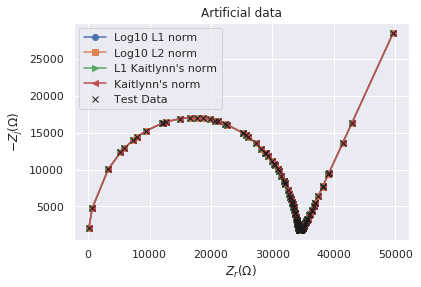

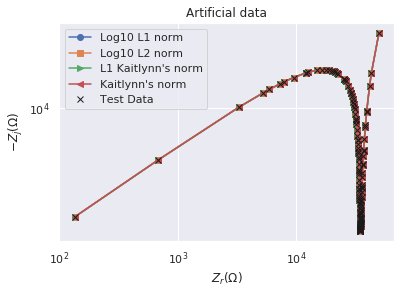

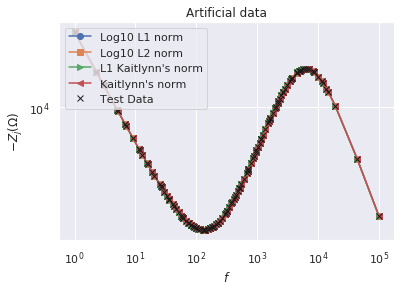

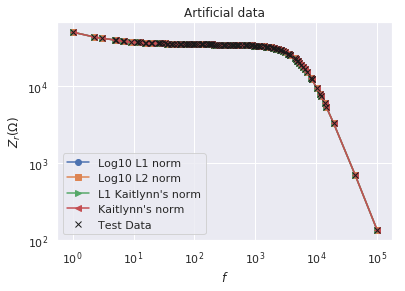

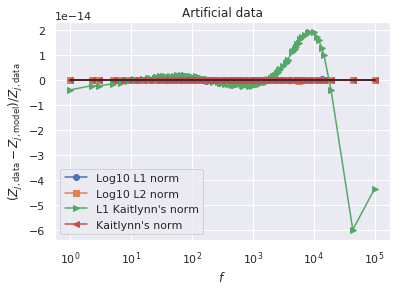

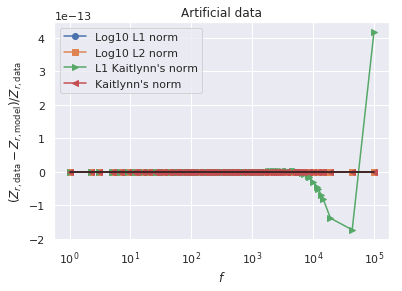

In [2]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
     'Artificial data')

# Run optimization on Blue Test Data

Optimization runtime 78.1706 seconds
Set of optima: [0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972956 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972956 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955 0.12972955
 0.1297295

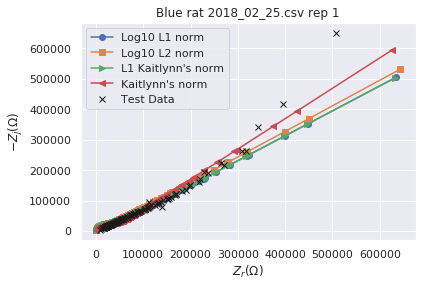

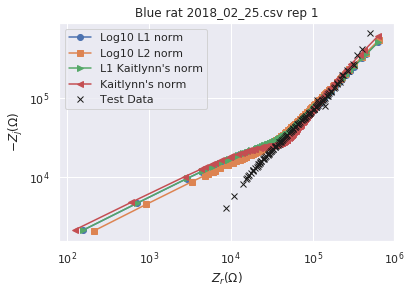

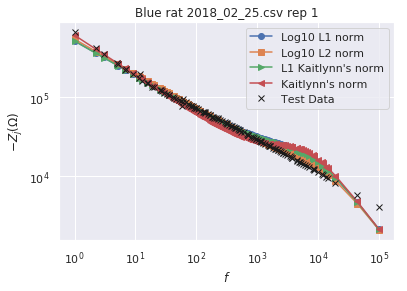

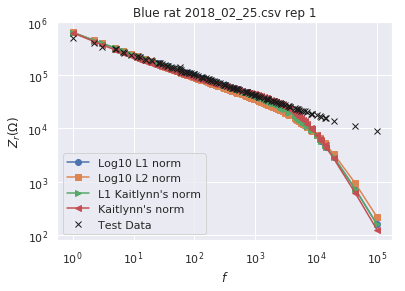

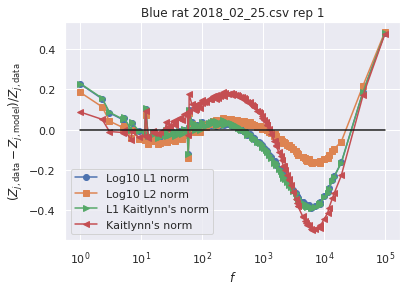

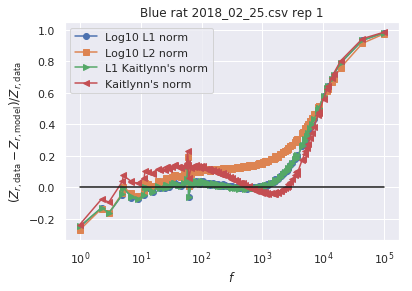

Optimization runtime 73.9586 seconds
Set of optima: [0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555326 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323 0.13555323
 0.1355532

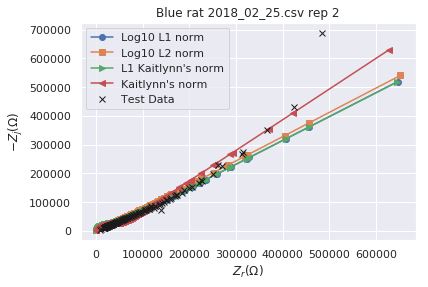

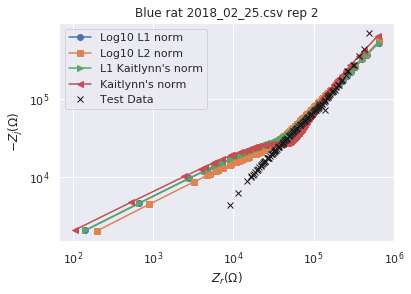

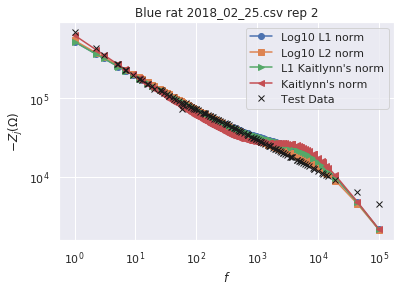

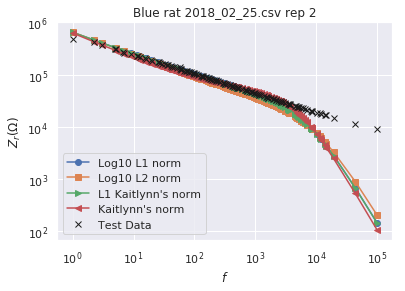

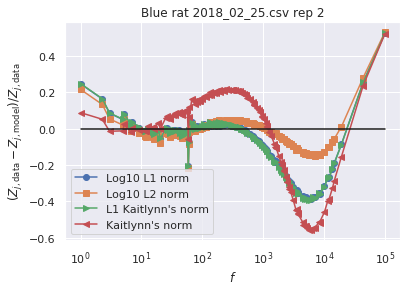

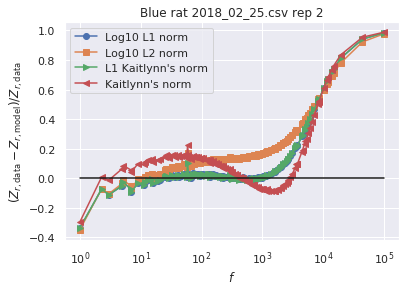

Optimization runtime 88.3100 seconds
Set of optima: [0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.2795582

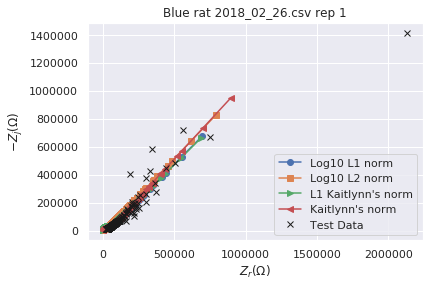

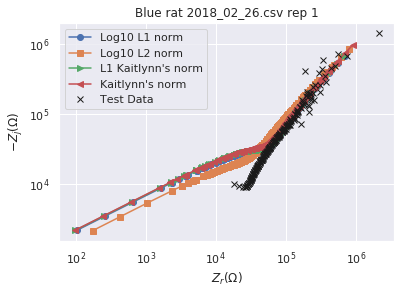

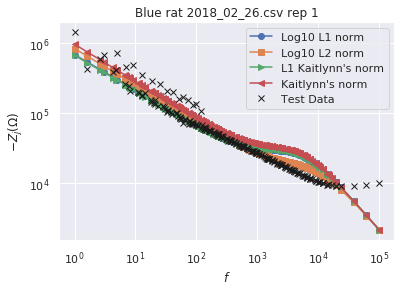

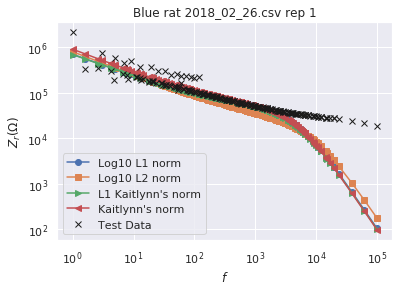

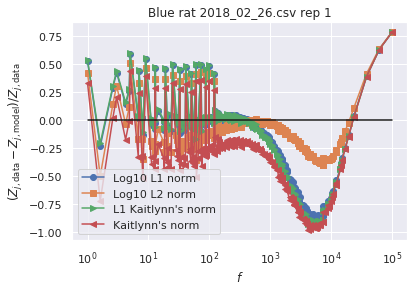

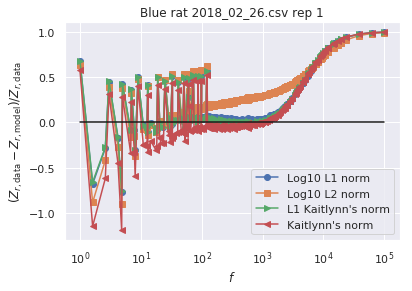

Optimization runtime 87.7957 seconds
Set of optima: [0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955831 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825 0.27955825
 0.2795582

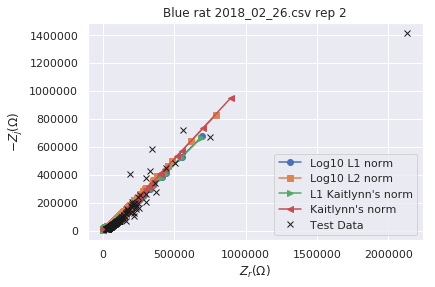

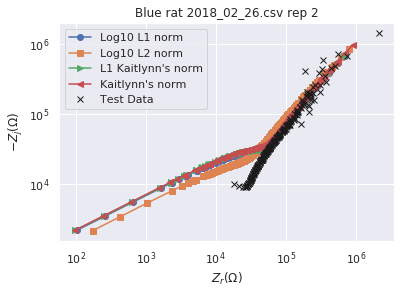

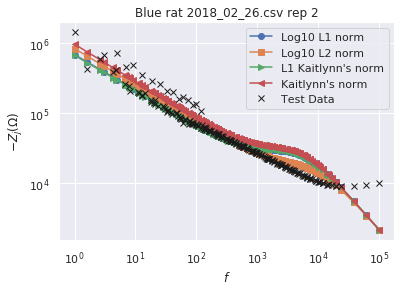

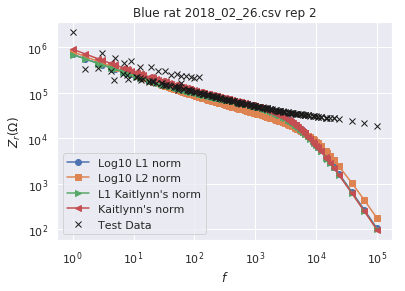

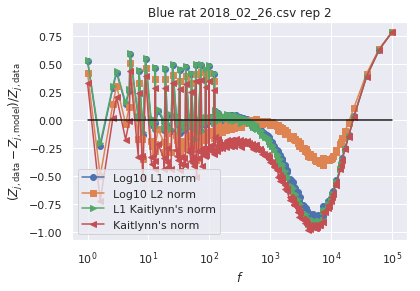

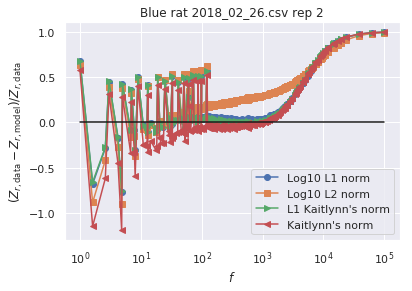

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


Optimization runtime 87.8135 seconds
Set of optima: [0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871 0.89884871
 0.8988487

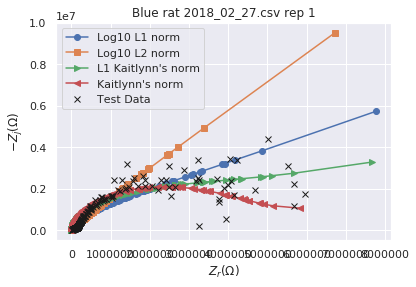

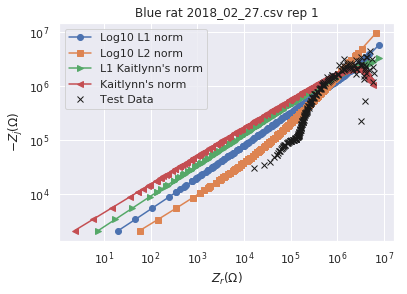

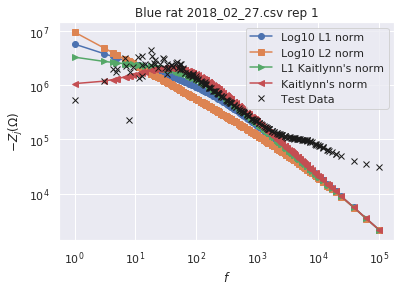

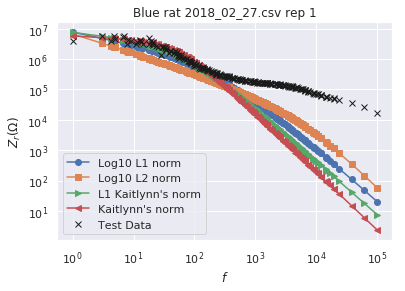

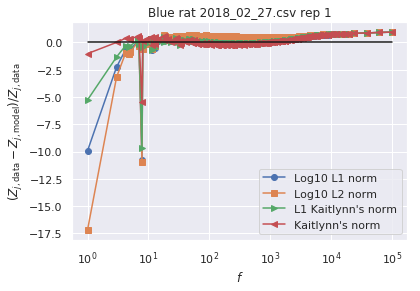

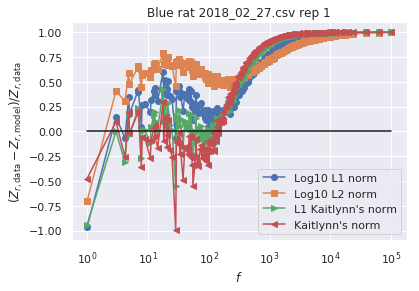

Optimization runtime 86.2573 seconds
Set of optima: [0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005 0.9195005
 0.9195005 0.9195005 0.91

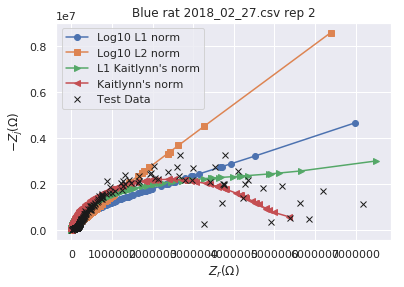

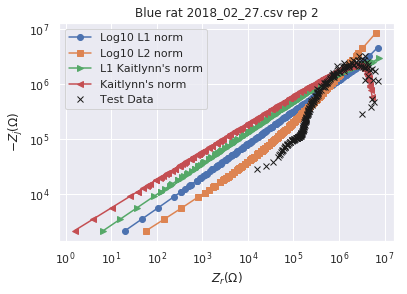

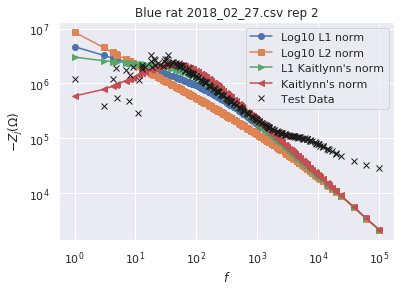

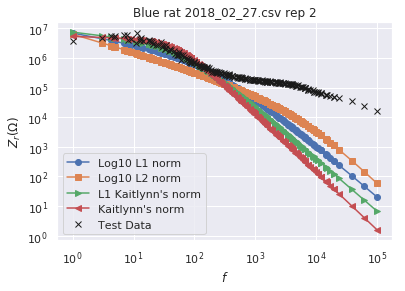

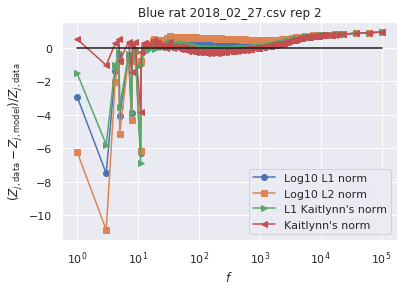

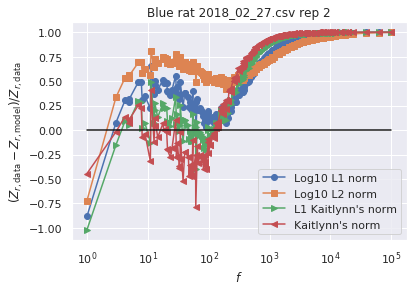

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10


Optimization runtime 83.2661 seconds
Set of optima: [0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713 0.94946713
 0.9494671

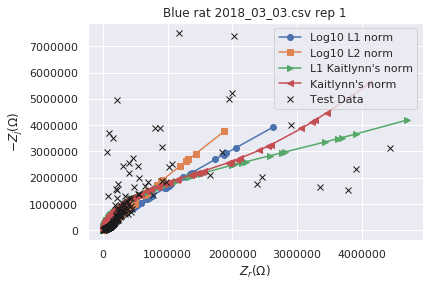

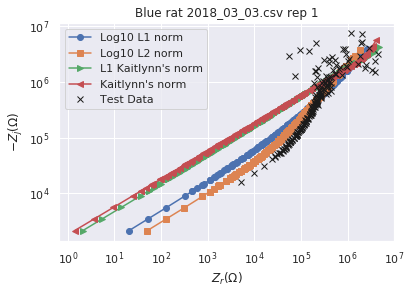

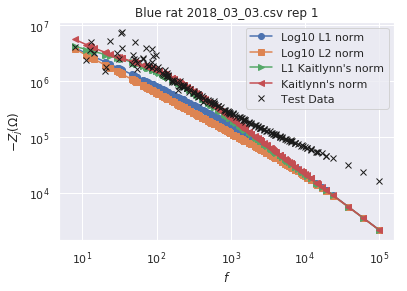

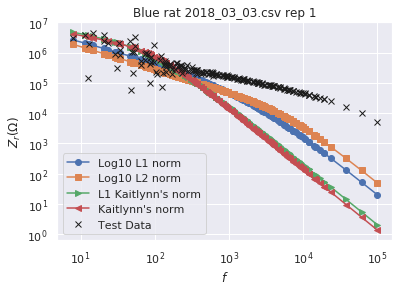

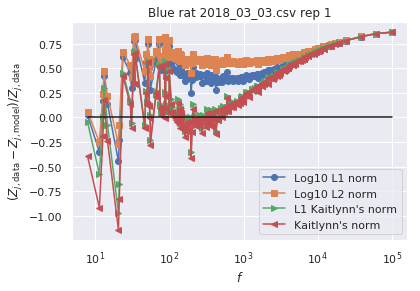

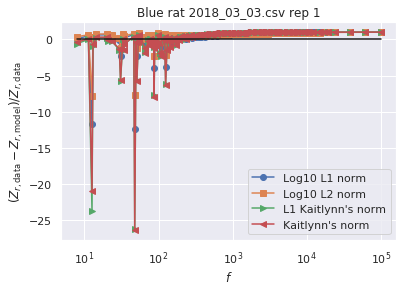

Optimization runtime 84.1696 seconds
Set of optima: [0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982 0.94512982
 0.9451298

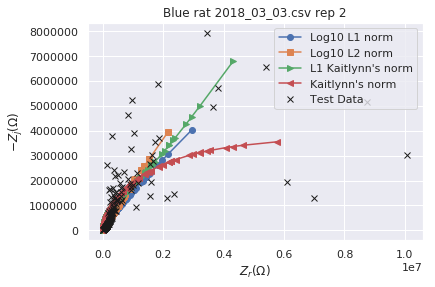

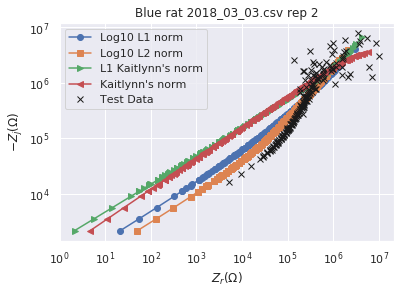

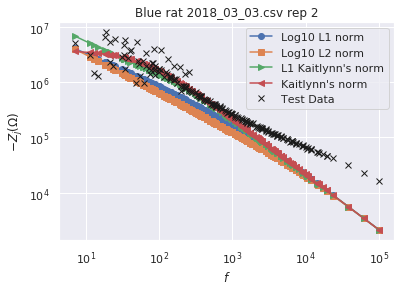

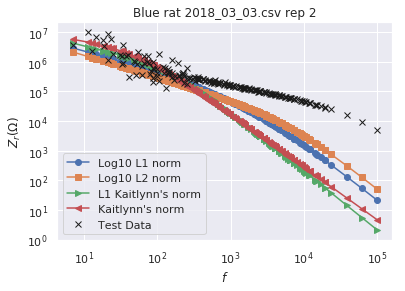

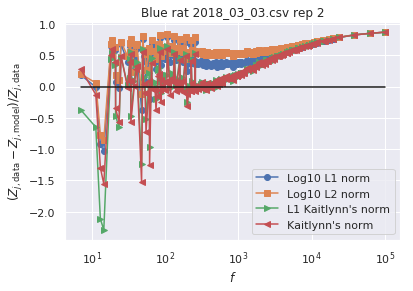

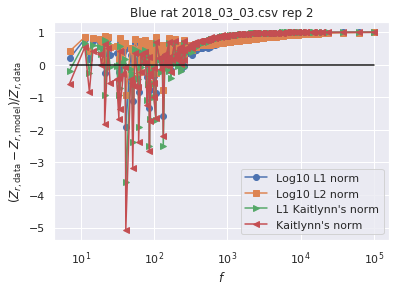

Optimization runtime 82.6490 seconds
Set of optima: [1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244 1.10647244
 1.1064724

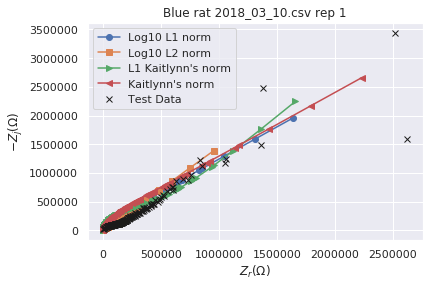

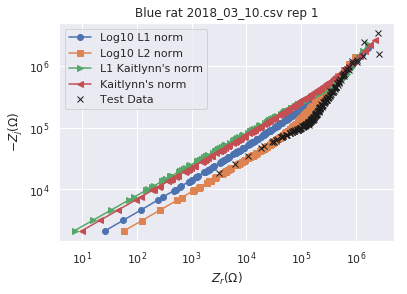

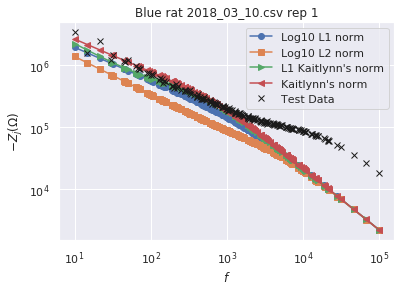

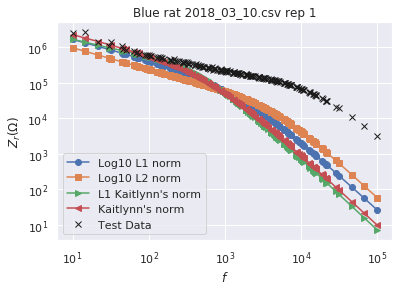

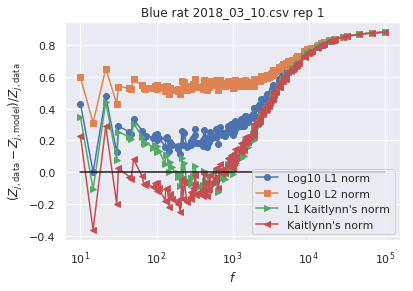

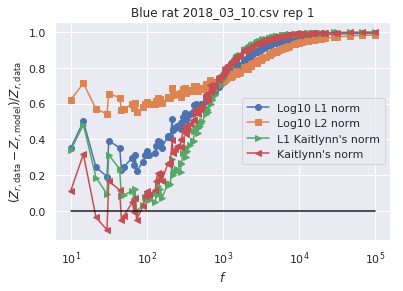

Optimization runtime 82.2461 seconds
Set of optima: [1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834 1.10020834
 1.1002083

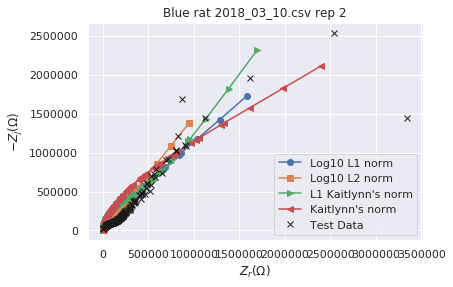

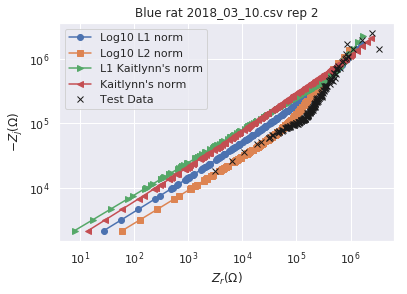

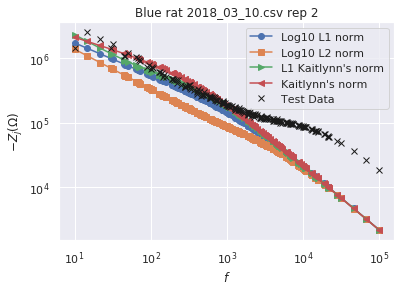

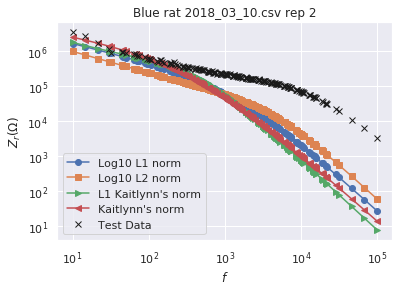

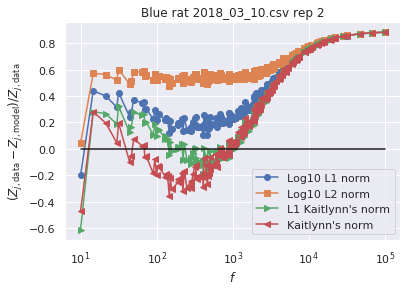

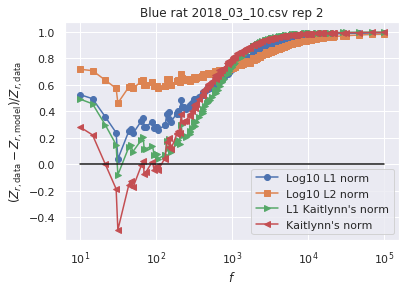

Stored 'res_l1' (ndarray)
Stored 'res_l2' (ndarray)
Stored 'res_lk1' (ndarray)
Stored 'res_lk2' (ndarray)
Stored 'l1_params' (list)
Stored 'l1_opts' (list)
Stored 'l2_params' (list)
Stored 'l2_opts' (list)
Stored 'lk1_params' (list)
Stored 'lk1_opts' (list)
Stored 'lk2_params' (list)
Stored 'lk2_opts' (list)


In [3]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

l1_params = []
l1_opts = []
l2_params = []
l2_opts = []
lk1_params = []
lk1_opts = []
lk2_params = []
lk2_opts = []

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        
        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # remove nans in zr and zj experimental data
        inds = np.where(np.isnan(np.log10(zj)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        inds = np.where(np.isnan(np.log10(zr)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        n = len(f)

        # run log10 optimizations
        xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
        xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

        # run normal optimizations
        xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
        xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

        # # save the results into the array
        res_l1[ind*2 + i, :5] = x_l1
        res_l1[ind*2 + i, 5] = opt_l1
        res_l2[ind*2 + i, :5] = x_l2
        res_l2[ind*2 + i, 5] = opt_l2
        res_lk1[ind*2 + i, :5] = x_lk1
        res_lk1[ind*2 + i, 5] = opt_lk1
        res_lk2[ind*2 + i, :5] = x_lk2
        res_lk2[ind*2 + i, 5] = opt_lk2
        
        # append results
        l1_params.append(xs_l1)
        l1_opts.append(opts_l1)
        l2_params.append(xs_l2)
        l2_opts.append(opts_l2)
        lk1_params.append(xs_lk1)
        lk1_opts.append(opts_lk1)
        lk2_params.append(xs_lk2)
        lk2_opts.append(opts_lk2)
        
        plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
             'Blue rat ' + data + ' rep ' + str(i+1))

%store res_l1
%store res_l2
%store res_lk1
%store res_lk2
%store l1_params
%store l1_opts
%store l2_params
%store l2_opts
%store lk1_params
%store lk1_opts
%store lk2_params
%store lk2_opts

# Example results for just one curve

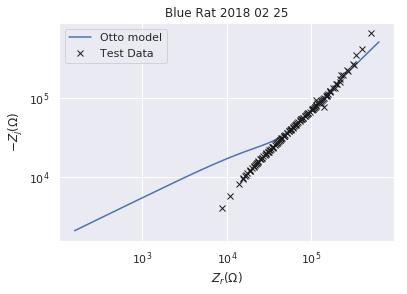

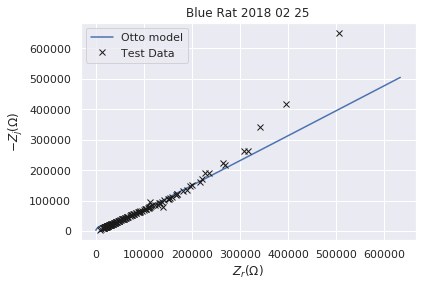

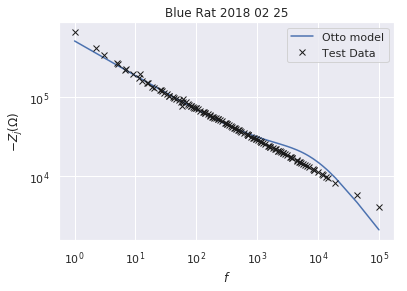

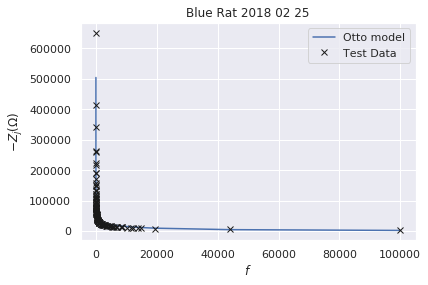

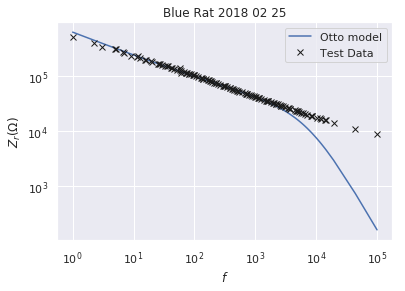

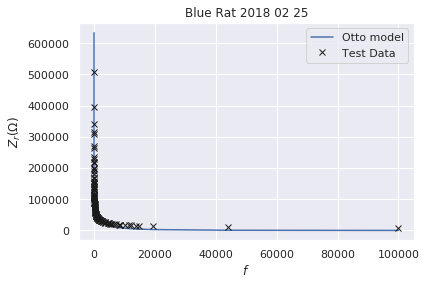

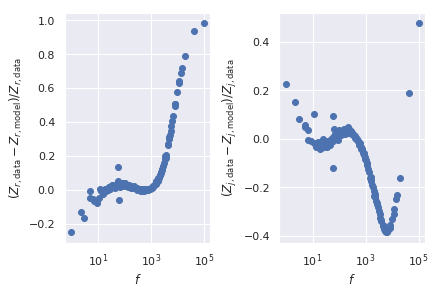

In [4]:
# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

# plot Kaitlynn's norm results
dataset = pd.read_csv(data_prefix+data_list[0])
j = 0*3
f = dataset.values[:, j]
n = len(f)
zr = dataset.values[:, j+1]
zj = dataset.values[:, j+2]
zr_lk, zj_lk = otto_model_create_data(res_l1[0, :5])
title = 'Blue Rat 2018 02 25'
plt.figure()
plt.title(title)
plt.plot(zr_lk, zj_lk, '-', label="Otto model")
plt.plot(zr, zj, 'xk', label='Test Data')

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logrj.pdf', dpi=300, bbox_inches='tight')


plt.figure()
plt.title(title)
plt.plot(zr_lk, zj_lk, '-', label="Otto model")
plt.plot(zr, zj, 'xk', label='Test Data')

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'rj.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj_lk, '-', label="Otto model")
plt.plot(f, zj, 'xk', label='Test Data')

plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logj.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj_lk, '-', label="Otto model")
plt.plot(f, zj, 'xk', label='Test Data')

plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'j.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr_lk, '-', label="Otto model")
plt.plot(f, zr, 'xk', label='Test Data')
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logr.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr_lk, '-', label="Otto model")
plt.plot(f, zr, 'xk', label='Test Data')
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'r.pdf', dpi=300, bbox_inches='tight')
plt.show()

# new plots based on Kaitlynn's suggestion
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(f, (zr-zr_lk)/zr, 'o')
ax[0].set_xscale('log')
ax[0].set_xlabel('$f$')
ax[0].set_ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')

ax[1].plot(f, (zj-zj_lk)/zj, 'o')
ax[1].set_xscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [5]:
columns = ['alpha CPE phase factor','K CPE magnitude factor', 'ren encapsulation resistance (k ohm)', 'rex extracellular resistance (k ohm)', 'am membrane area in cm**2', 'objective value']
index_rows = ['blue rat 2018_02_25 rep 1', 'blue rat 2018_02_25 rep 2', 'blue rat 2018_02_26 rep 1', 'blue rat 2018_02_26 rep 2', 'blue rat 2018_02_27 rep 1', 'blue rat 2018_02_27 rep 2',
             'blue rat 2018_03_03 rep 1', 'blue rat 2018_03_03 rep 2', 'blue rat 2018_03_10 rep 1', 'blue rat 2018_03_10 rep 2']
pd_l1 = pd.DataFrame(res_l1, index=index_rows, columns=columns)
pd_l2 = pd.DataFrame(res_l2, index=index_rows, columns=columns)
pd_lk1 = pd.DataFrame(res_lk1, index=index_rows, columns=columns)
pd_lk2 = pd.DataFrame(res_lk2, index=index_rows, columns=columns)

# Log10 L1 Norm

In [6]:
pd_l1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.438272,0.563601,24.415873,1.000000,1000.000000,0.129730
blue rat 2018_02_25 rep 2,0.442069,0.547550,27.248690,1.000000,999.999999,0.135553
blue rat 2018_02_26 rep 1,0.509265,0.416516,42.484963,1.000476,999.999997,0.279558
blue rat 2018_02_26 rep 2,0.509265,0.416516,42.484963,1.000000,999.999997,0.279558
blue rat 2018_02_27 rep 1,0.385164,0.050209,108.889533,1.000000,1000.000000,0.898849
blue rat 2018_02_27 rep 2,0.357436,0.060937,81.286897,1.000000,999.999977,0.919501
blue rat 2018_03_03 rep 1,0.572297,0.020117,208.390396,1.000000,1000.000000,0.949467
blue rat 2018_03_03 rep 2,0.545227,0.022810,192.713503,1.000000,1000.000000,0.945130
blue rat 2018_03_10 rep 1,0.529470,0.041573,156.969746,1.000000,1000.000000,1.106472
blue rat 2018_03_10 rep 2,0.504090,0.050903,150.445608,1.000000,1000.000000,1.100208


# Log10 L2 Norm

In [7]:
pd_l2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.445694,0.535021,16.336003,1.000000,1000.000000,0.229182
blue rat 2018_02_25 rep 2,0.447188,0.526119,17.730684,9690.370878,1000.000000,0.239896
blue rat 2018_02_26 rep 1,0.521543,0.339414,23.966177,1.000000,1000.000000,0.356251
blue rat 2018_02_26 rep 2,0.521543,0.339414,23.966177,1.000055,999.999999,0.356251
blue rat 2018_02_27 rep 1,0.590497,0.027805,68.871332,1.000000,999.999975,0.866484
blue rat 2018_02_27 rep 2,0.576421,0.031226,67.408369,1.000000,1000.000000,0.876655
blue rat 2018_03_03 rep 1,0.665210,0.015513,86.140231,1.000000,999.999996,0.814236
blue rat 2018_03_03 rep 2,0.639784,0.017434,83.640554,1.000000,1000.000000,0.818617
blue rat 2018_03_10 rep 1,0.607152,0.046080,73.493411,1.000402,999.999998,0.943124
blue rat 2018_03_10 rep 2,0.609114,0.046091,73.013810,1.000010,1000.000000,0.942767


# L1 Kaitlynn's Norm

In [8]:
pd_lk1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.438023,0.565634,24.606051,1.000000,1000.000000,0.164216
blue rat 2018_02_25 rep 2,0.441956,0.548567,27.442357,1.000000,1000.000000,0.168500
blue rat 2018_02_26 rep 1,0.507886,0.426321,44.731486,1.000000,1000.000000,0.318204
blue rat 2018_02_26 rep 2,0.507886,0.426321,44.731486,1.000000,1000.000000,0.318204
blue rat 2018_02_27 rep 1,0.234925,0.076727,1.000000,1.000000,999.999992,0.550836
blue rat 2018_02_27 rep 2,0.220988,0.081418,1.000000,1.055860,1000.000000,0.558636
blue rat 2018_03_03 rep 1,0.462229,0.029794,2152.983152,1.000000,1000.000000,0.625930
blue rat 2018_03_03 rep 2,0.641281,0.010000,2154.782766,665.011089,1000.000000,0.644090
blue rat 2018_03_10 rep 1,0.649643,0.024806,624.929719,1.000000,999.999570,0.726176
blue rat 2018_03_10 rep 2,0.639627,0.024696,580.596583,1.000000,1000.000000,0.728470


# L2 Kaitlynn's (original) norm

In [9]:
pd_lk2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.499877,0.474499,34.901026,1.000000,999.999999,1.300292e+09
blue rat 2018_02_25 rep 2,0.520781,0.445896,41.961290,1.000556,999.999985,2.083328e+09
blue rat 2018_02_26 rep 1,0.532448,0.292640,45.622136,1.013808,1000.000000,7.689999e+11
blue rat 2018_02_26 rep 2,0.532448,0.292640,45.622133,1.000000,1000.000000,7.689999e+11
blue rat 2018_02_27 rep 1,0.098097,0.140366,1.000000,1.000000,999.999894,7.640305e+12
blue rat 2018_02_27 rep 2,0.053722,0.167658,1.000000,1.000000,999.998463,5.221243e+12
blue rat 2018_03_03 rep 1,0.699655,0.010000,3294.483528,9777.240518,1.000000,4.539445e+13
blue rat 2018_03_03 rep 2,0.218680,0.058341,1.000000,1.000000,1000.000000,7.353629e+13
blue rat 2018_03_10 rep 1,0.533189,0.030295,440.626770,1.000000,999.999995,1.349814e+12
blue rat 2018_03_10 rep 2,0.410150,0.055262,262.212595,1.000000,999.999957,1.493452e+12
